In [121]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def draw(x):
    with torch.no_grad():
        img_size = 28
        plt.imshow(x.cpu().numpy().reshape((img_size,img_size)), cmap='gray');
        plt.axis('off');

In [122]:
ds_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [123]:
batch_size = 128

train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 200), 
            nn.ReLU(),
            nn.Linear(200, 10), 
            nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)
        
        
    def forward(self, x):
        return self.network(x)
    
    
    def learn(self, dl, optimizer=None, epochs=10):
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x, t in dl:
                x = x.to(device)  
                t = t.to(device)
                y = self(x)
                loss = self.loss_fcn(y, t)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()*len(t)
            self.losses.append(total_loss/len(dl.dataset))
        plt.plot(self.losses)
        plt.yscale('log')
        plt.show()

In [5]:
#net = Network()
#optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
#net.learn(train_dl, optimizer, epochs=20)
#torch.save(net.cpu(), 'Pretrained_mnist.pt')

In [28]:
net = torch.load('Pretrained_mnist.pt')

In [29]:
def accuracy(net, dl):
    net.eval()
    correct = 0
    with torch.no_grad():
        for x,t in dl:
            x.to(device)
            t.to(device)
            result = torch.argmax(net(x), dim = 1)
            correct += torch.sum(result == t).item()
    return correct/len(dl.dataset)

print(f'Accuracy = {accuracy(net, test_dl)*100.:0.2f}%')

Accuracy = 97.93%


# FGSM

In [8]:
# Untargeted attack
def fgsm(net, x, t, eps):
    x_adv = x.clone().to(device)
    x_adv.requires_grad = True
    y = net(x_adv)
    loss = net.loss_fcn(y, t) # compute the loss

    net.zero_grad()
    loss.backward() # gradient obtained
    with torch.no_grad():
        x_adv = x_adv + eps * (torch.sign(x_adv.grad))
    return x_adv

# $\epsilon = 0.2 $

Accuracy = 0.17%


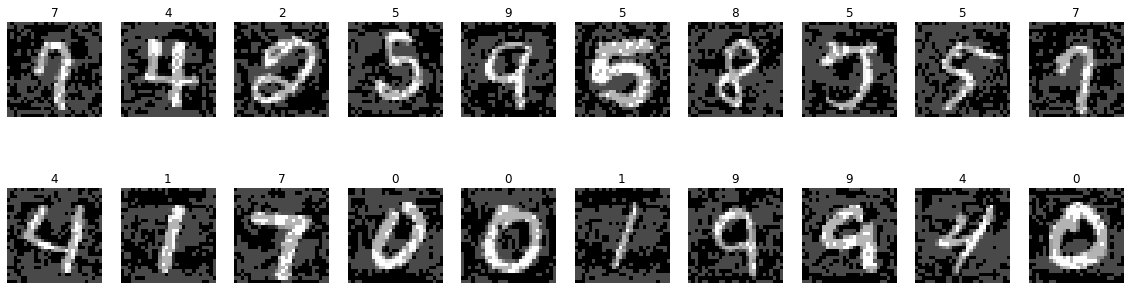

In [9]:
net = torch.load('Pretrained_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.2)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

We see here despite the adversarial digits looks to match their label exactly, the network gives a low accuracy. And the digits are a little bit vague.

# $\epsilon = 0.1$

Accuracy = 3.60%


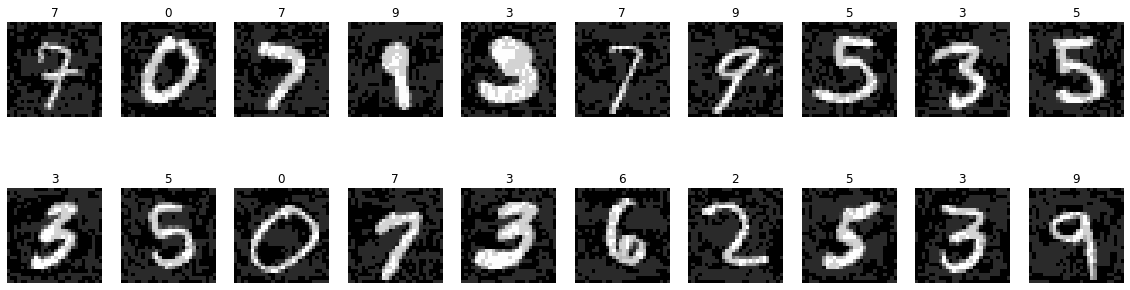

In [10]:
net = torch.load('Pretrained_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.1)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

# $\epsilon = 0.5$

Accuracy = 0.00%


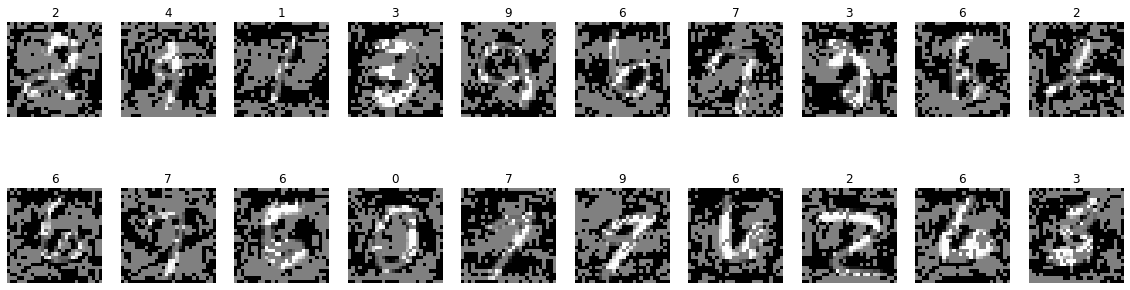

In [11]:
net = torch.load('Pretrained_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.5)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

As $\epsilon$ goes smaller, the accuracy goes a little higher (but still pretty low), the digits are more clear, so that it would be hard to find out that they are generated adversial digits.

As $\epsilon$ goes larger, the accuracy goes a little lower, the digits are more vague, and it can be easily seen to be generated adversial digits.

In [20]:
class RobustNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 200), 
            nn.ReLU(),
            nn.Linear(200, 10), 
            nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)
        
        
    def forward(self, x):
        return self.network(x)
    
    
    def learn(self, dl, optimizer=None, epochs=10, eps = 0.2):
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x, t in dl:
                
                x_adv = x.clone().to(device)
                x_adv.requires_grad = True
                y = self(x_adv)
                loss = self.loss_fcn(y, t) # compute the loss
                self.network.zero_grad()
                loss.backward() # gradient obtained
                with torch.no_grad():
                    x_adv = x_adv + eps * (torch.sign(x_adv.grad))
        
                y = self(x_adv)
                loss = self.loss_fcn(y, t)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()*len(t)
            self.losses.append(total_loss/len(dl.dataset))
        plt.plot(self.losses)
        plt.yscale('log')
        plt.show()

100%|██████████| 20/20 [03:48<00:00, 11.44s/it]


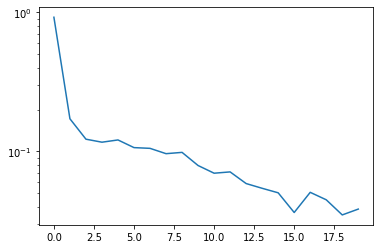

In [21]:
# net = RobustNetwork()
# optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
# net.learn(train_dl, optimizer, epochs=20)
# torch.save(net.cpu(), 'Pretrained_robuts_mnist.pt')

In [113]:
net = torch.load('Pretrained_robuts_mnist.pt')
print(f'Accuracy = {accuracy(net, test_dl)*100.:0.2f}%')

Accuracy = 85.56%


# $\epsilon = 0.1$

Accuracy = 86.84%
Accuracy = 98.66%


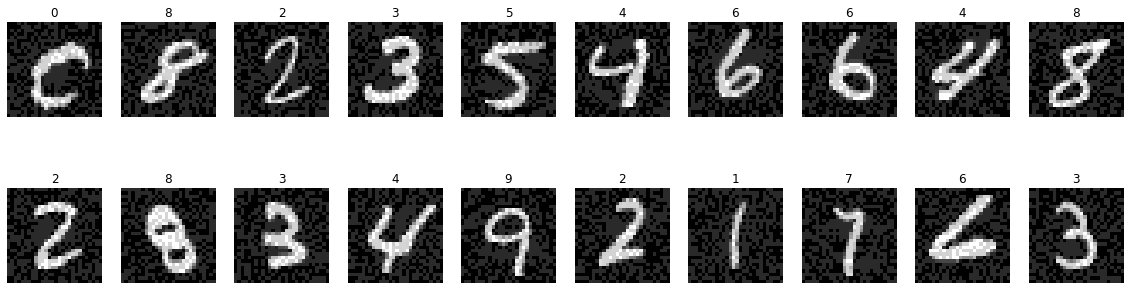

In [106]:
net = torch.load('Pretrained_robuts_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.1)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

# $\epsilon = 0.2$

Accuracy = 98.91%


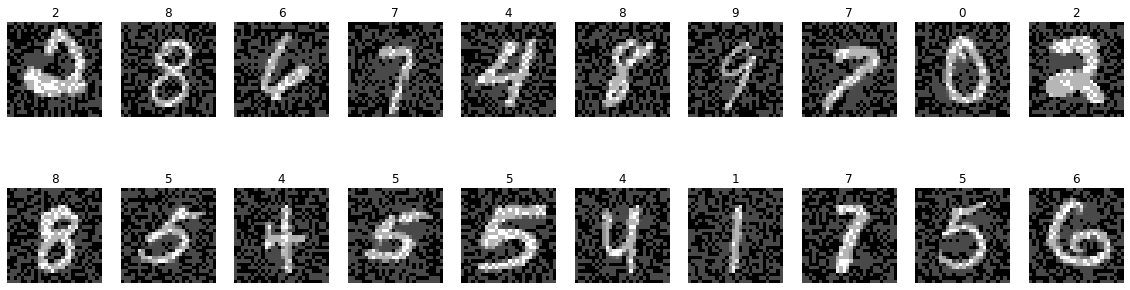

In [25]:
net = torch.load('Pretrained_robuts_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.2)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

# $\epsilon = 0.5$

Accuracy = 98.68%


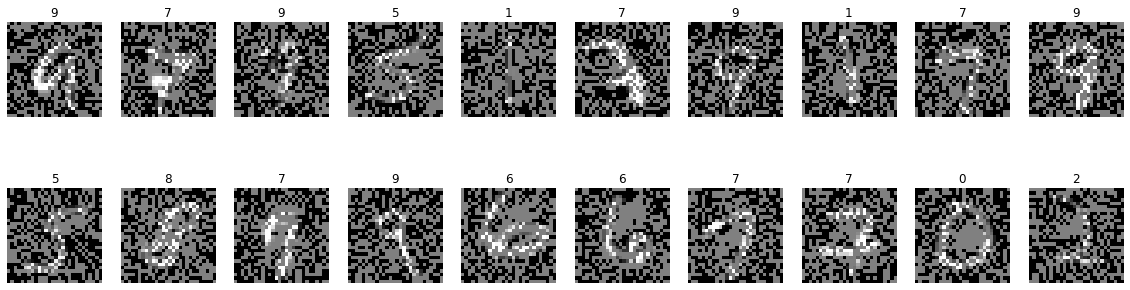

In [26]:
net = torch.load('Pretrained_robuts_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = fgsm(net, x_adv,t_adv, eps = 0.5)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

We can see the accuracy has been increased significantly. The network is robust against FGSM.

# PGD

In [124]:
# Untargeted attack
def pgd(net, x, t, num_step, step_size, eps):
    x_adv = x.clone().to(device)
    x_adv.requires_grad = True
    for i in range(num_step):
        y = net(x_adv)
        loss = net.loss_fcn(y, t)
        net.zero_grad()
        loss.backward()
        with torch.no_grad():
            x_adv = x_adv + step_size * (torch.sign(x_adv.grad))
            delta = x_adv - x
            delta[delta > eps] = eps
            delta[delta < -eps] = -eps
            x_adv = (delta + x).detach().clone().to(device)
            x_adv.requires_grad = True
    return x_adv.detach()

In [125]:
class RobustPGDNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 200), 
            nn.ReLU(),
            nn.Linear(200, 10), 
            nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)
        
        
    def forward(self, x):
        return self.network(x)
    
    
    def learn(self, dl, optimizer=None, epochs=10, num_step = 6,  step_size = 0.04, eps = 0.2):
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            for x, t in dl:
                x_adv = x.clone().to(device)
                x_adv.requires_grad = True

                for i in range(num_step):
                
                    y = self(x_adv)
                    loss = self.loss_fcn(y, t)
                    self.network.zero_grad()
                    loss.backward()
                    with torch.no_grad():
                        x_adv = x_adv + step_size * (torch.sign(x_adv.grad))
                        delta = x_adv - x
                        delta[delta > eps] = eps
                        delta[delta < -eps] = -eps
                        x_adv = (delta + x).detach().clone().to(device)
                        x_adv.requires_grad = True
        
                y = self(x_adv)
                loss = self.loss_fcn(y, t)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                self.losses.append(loss.item()*len(t))
        plt.plot(self.losses)
        plt.yscale('log')
        plt.show()

100%|██████████| 20/20 [08:13<00:00, 24.67s/it]


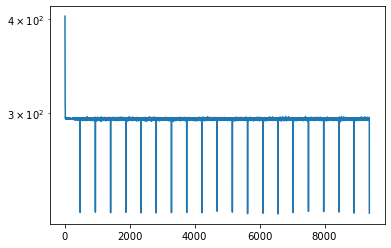

In [126]:
net = RobustPGDNetwork()
optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
net.learn(train_dl, optimizer, epochs=20)
torch.save(net.cpu(), 'Pretrained_robuts_pgd_mnist.pt')

In [127]:
net = torch.load('Pretrained_robuts_pgd_mnist.pt')

Accuracy = 11.35%


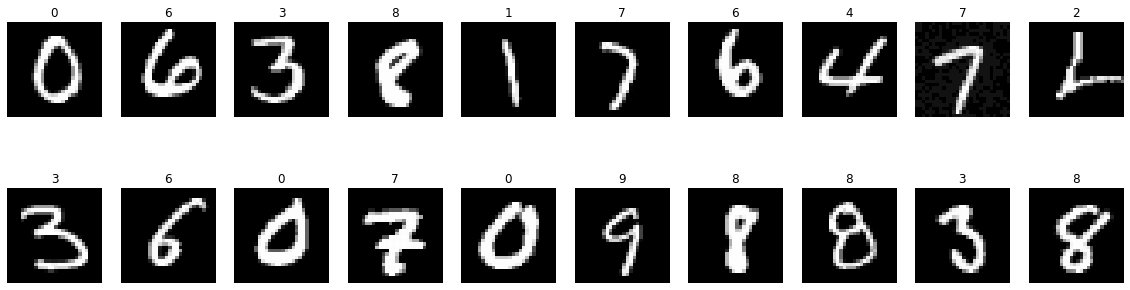

In [128]:
net = torch.load('Pretrained_robuts_pgd_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = pgd(net, x_adv,t_adv, 6, 0.04 ,0.1)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_pgd_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

Accuracy = 44.15%


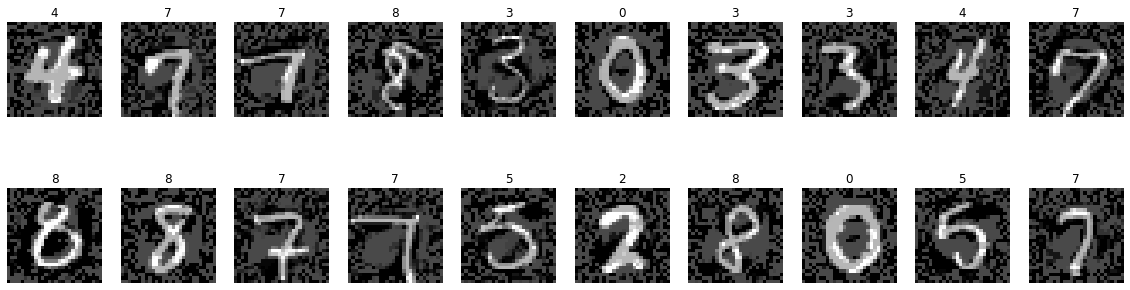

In [119]:
net = torch.load('Pretrained_robuts_pgd_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = pgd(net, x_adv,t_adv, 6, 0.04 ,0.2)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_pgd_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());

Accuracy = 34.80%


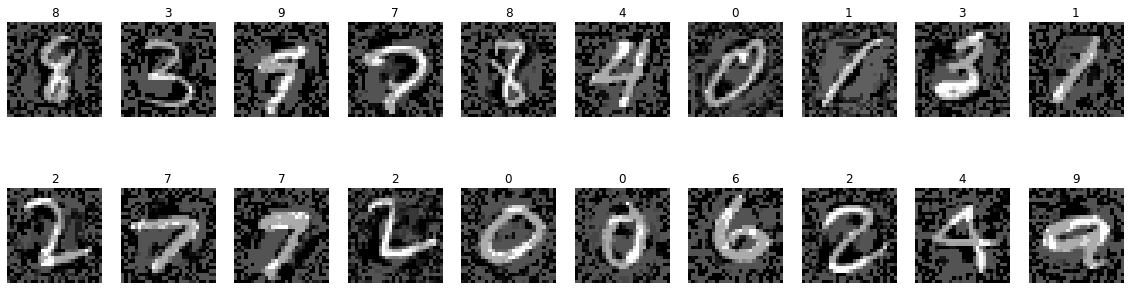

In [120]:
net = torch.load('Pretrained_robuts_pgd_mnist.pt')
test_dl_adv = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=True)
x_adv,t_adv = next(iter(test_dl_adv))
x_adv = pgd(net, x_adv,t_adv, 6, 0.04 ,0.5)

ds = torch.utils.data.TensorDataset(x_adv,t_adv)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

net = torch.load('Pretrained_robuts_pgd_mnist.pt')
acc = accuracy(net, dl)
print(f'Accuracy = {acc*100.:0.2f}%')

plt.figure(figsize=(20,30))

for i in range(20):
    plt.subplot(10,10,i+1)
    num = random.randint(0, len(x_adv)-1)
    draw(x_adv.data[num]); plt.title(t_adv[num].item());